## Problem 1. Vanilla option prices

Produce graphs of European call option prices as functions of the underlying stock price for several values of the expiration time. Use the parameters $K=1$ (strike price), $\sigma = 0.25$ (volatility), $S_0 \in [0.5,1.5]$ (initial stock price), $T \in \{0,\ \frac{1}{12},\ \frac{1}{3},\ \frac{1}{2},\ 1\}$ (expiration time), where the time is expressed in years. Assume the risk-free interest rate is 0.

*Requirements.* You must first write a function which computes the price of a call option. The final answer must contain a graph with axes "Stock price" and "Option price" which shows the 5 functions - the option prices with different expiration times.

In [ ]:
from math import *
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

In [ ]:
# Model parameters
K = 1                           # Strike price
sigma = 0.25                    # Volatility
S = np.linspace(0.5, 1.5, 100)  # Initial prices of the stock
T = [0, 0.25, 0.5, 1]           # Expiration times

$C = S*N(d_1)-PV(K)*N(d_2) \ where
\\ d_1=\frac{ln(S/PV(K))}{\sigma \sqrt T}+ \frac{\sigma \sqrt T}{2}
\\ d_2 =d_1-\sigma \sqrt T$

Risk-free rate = 0% => PV(K)=K

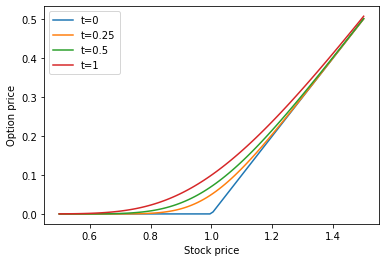

In [ ]:
### Solution ###

def call_price(s, sigma, t, k):
  #Using the Black-Scholes formula for call option price, we get:
  if t != 0:
    d_1 = np.log(s / k) / (sigma * np.sqrt(t)) + (sigma * np.sqrt(t)) / 2
    d_2 = d_1 - (sigma * sqrt(t))
    c = s * st.norm.cdf(d_1) - K * st.norm.cdf(d_2)
  else:
   #for t = 0, we can compute option price using: max(S-K, 0)
    c = np.maximum(s - k, 0)
  return c

# Plot the price for different t
for t in T[0:]:
  plt.plot(S, call_price(S, sigma, t, K), label = 't=' + str(t))
plt.xlabel('Stock price')
plt.ylabel('Option price')
plt.legend()

## Problem 2. Replication of a vanilla option

Consider the problem of replicating a European call option with expiration time $T$ and strike price $K$. Assume that the replicating portfolio is rebalanced $n$ times during the time period $[0,T]$ (each $\Delta t = T/n$ units of time). Due to the discrete rebalancing, there will be a replication error, since the Black-Scholes formula assumes the portfolio is rebalanced in a continuous way (which is impossible in practice). You will need to estimate this replication error by simulation.

The replication procedure works as follows: you observe the stock price and at each moment of time $t_i = i\Delta t$ you find the replicating portfolio. Recall that the replicating portfolio can be defined by specifying the amount of stock in the portfolio $H_{t_i} = V'_s(t_i,S_{t_i})$ and the amount of cash $G_{t_i} = V(t_i,S_{t_i}) - H_{t_i}S_{t_i}$ (we will assume zero risk-free rate, so the riskless asset price is $B_t=1$). At the next moment of time the value of the portfolio changes due to the change of the stock price: $V_{t_{i+1}} = V_{t_i} + H_{t_i}(S_{t_{i+1}} - S_{t_i})$. Then again you find the necessary amount of stock in the portfolio, and the procedure continues.

You need to do the following.
1. Produce $m$ random trajectories of the price process in the time interval $[0,T]$ with step $\Delta t = T/n$.
2. For each trajectory, at each time step find the replicating portfolio. Assume the initial portfolio value $V_0$ is equal to the option's price (compute it using the function from Problem 1).
3. For each trajectory, find the difference of the value of the replicating portfolio at time $T$ and the option's payoff.
4. Plot the distribution of the obtained differences as a histogram.

Use the parameters of the model from the next cell. Assume the risk-free interest rate is 0.

*Requirements.* The final answer must contain a histogram of the distribution of the replication error.

In [ ]:
# Model parameters
s = 1         # Initial stock price
sigma = 0.25  # Volatility
t = 0.25      # Expiration time (= three months)
k = 1         # Strike price
steps = 120   # Number of time steps, n
paths = 1000  # Number of trajectories, m

SDE od Geometric brownian motion:


$S(t) = S(t) e^{(r  - \frac{1}{2} \sigma^2) t + \sigma W_t )}
\\
\\ delta = \frac{\partial C}{\partial S} e^{-rT} * N(d_1)$

Option price: 0.04983533805849444


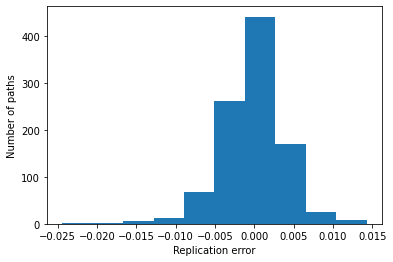

In [ ]:
### Solution ###

def call_delta(s, sigma, t, k):
    delta = st.norm.cdf(np.log(s / k) / (sigma * np.sqrt(t)) + (sigma * np.sqrt(t)) / 2) * np.exp(0 * t) #r = 0
    return delta
    pass

def simulate(s, sigma, t, steps, paths):
    # Simulating m trajectories with n time steps
    S = np.zeros((paths, steps + 1))
    S[:, 0] = s
    dt = t / steps
    for i in range(steps):
        z = np.random.normal(size = paths)
        S[:, i + 1] = S[:, i] * np.exp((0 - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z) #r = 0
    return S
    pass

C = call_price(s, sigma, t, k)
print("Option price:", C)

S = simulate(s, sigma, t, steps, paths)
err = []
dt = t / steps
for i in range(paths):
  # value of portfolio
  V_port = np.zeros(steps + 1)
  V_port[0] = C
  for j in range(steps):
    delta = call_delta(S[i, j], sigma, t - j * dt, k)
    V_port[j + 1] = V_port[j] + delta * (S[i, j + 1] - S[i, j])
  call_payoff = max(S[i, -1] - k, 0)
  #replication error
  err.append(V_port[steps] - call_payoff)

plt.hist(err)
plt.xlabel("Replication error")
plt.ylabel("Number of paths")
plt.show()

## Problem 3. Pricing a barrier option using Monte-Carlo

Consider an option which allows to buy stock at time $T$ for price $K$ under the condition that the price does not exceed some _barrier_ $B$ in the whole time interval $[0,T]$. If the price exceeds the barrier, the option becomes worthless and cannot be exercised. Verification of the condition that the price does not exceed $B$ is performed at discrete moments of time $t_i = i\Delta t$, where $\Delta t = T/n$, $i=0,1,...,n$; the prices between these moments are not taken into account.

Using the Monte-Carlo method, find the price of such an option. Use the parameters from the next cell. Assume the interest rate in zero.

Recall that in order to find the price of a contingent clam, we can compute $E^Q X$, where $Q$ is the equivalent martingale measure and $X$ is the payoff of the option. In this problem, the payoff can be defined as follows: $X = (S_T-K)^+ I(S_{t_i}\le B\ \text{for all}\ i=0,\dots,n)$, where $I(\dots)$ is the indicator function.

*Requirements*. The answer must contain the estimate of the option price obtained by the Monte-Carlo method, and the margin of error (half of the length of the confidence interval) at the confidence level given in the next cell. Your implementation must use simulation in batches as described in the notebook for Lecture 5 (section 2.2). The procedure must not rely on the hard-coded values of the confidence probability and the simulation error, so that it is possible to change them in the next cell.

In [ ]:
s = 1             # Initial stock price
sigma = 0.25      # Volatility
t = 0.25          # Expiration time
k = 1             # Strike price
b = 1.15          # Barrier
steps = 60        # Number of time steps, n
error = 1e-4      # Desired error of the Monte-Carlo method
conf_prob = 0.95  # Confidence probability

In [ ]:
### Solution ###
max_sim = 10000000
batch_size = 1000
x_mean = 0      # estimate of `E(X)`
x_sq_mean = 0   # estimate of `E(X^2)`
se = 0           # standard error of x
n = 0           # batches counter (number of paths = n*batch_size)
z = st.norm.ppf((1 + conf_prob) / 2)
while (n==0 or (z*se/sqrt(n*batch_size) > error and n*batch_size < max_sim)):
    S = simulate(s, sigma, t, steps, batch_size)#using out previous function for simulation
    x = np.where(np.all(S <= b, axis = 1), np.maximum(S[:, -1] - k, 0), 0)#checking by rows condition on barrier and calculating the payoff
    x_mean = (x_mean*n + np.mean(x))/(n+1)
    x_sq_mean = (x_sq_mean*n + np.mean(x**2)) / (n+1)
    se = sqrt((n+1)*batch_size/((n+1)*batch_size-1) * (x_sq_mean - x_mean**2))
    n += 1

margin_err = z*se/sqrt(n*batch_size)

print("Option price:" "%.16f" % x_mean)
print("Margin of error:" "%.16f" % margin_err)

Option price:0.0146373720872639
Margin of error:0.0000999128206025


## Problem 4. Replication of a barrier option

Similarly to Problem 2, implement a replication procedure for the barrier option from Problem 3. The main difficulty here consists in that now you need to compute the delta of the option by Monte-Carlo simulation. Moreover, at each time step it is necessary to know not only the current spot price, but also whether the barrier has been crossed, since the delta will depend on than (equivalently, it is possible to store the running maximum of the price process). See Lecture 5 for details in a similar setting but in discrete time.

1. Write a function `barrier_price(i, s, m)` which computes the price of the option at time `T[i]` given that the stock price at this time is equal to `s` and the maximum price until this time is equal to `m`. Use your code from Problem 3.
2. Write a function `barrier_delta(i, s, m)` which computes the delta of the option using numerical differentiation (`scipy.misc.derivative`). Pay attention to the parameter `dx` of `derivative`, since the default value `dx=1` may lead to incorrect computation as it will try to call the pricing function with a negative argument `s`. As a solution to this issue, you can set `dx=min(0.02, s/2)`, where `s` is the stock price. A sample implementation is provided below, you can use it if fits your replication procedure code.
3. Modify the simulation procedure from Problem 2. Let it now work for only one trajectory, but return the whole trajectory of the value of the replicating portfolio. Assume that the initial portfolio value is equal to the option price.

*Requirements.* The answer must contain a graph of the two processes: the option price and the value of the replicating portfolio at the moments `T[i]` (ideally, they must coincide, but this won't happen because of the replication error).

*Remark.* The replication procedure may take quite a long time.


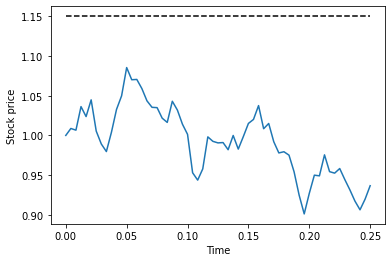

In [ ]:
# Model parameters
s = 1             # Initial stock price
sigma = 0.25      # Volatility
t = 0.25          # Expiration time
k = 1             # Strike price
b = 1.15          # Barrier
steps = 60        # Number of time steps, n
error = 1e-4      # Desired Monte-Carlo error
conf_prob = 0.95  # Confidence probability

T = np.linspace(0, t, steps+1)
# Price trajectory for which you must construct the replicating portfolio
W = np.cumsum(np.concatenate([[0], np.random.randn(steps)*sqrt(t/steps)]))
S = s*np.exp(sigma*W - 0.5*sigma**2*T)

plt.plot(T, S)
plt.xlabel("Time")
plt.ylabel("Stock price")
plt.plot(T, np.full_like(T, b), linestyle="dashed", color="black")
plt.show()

<ipython-input-18-6cdab464524c>:35: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  return derivative(lambda x: barrier_price(i, x, m), s, dx=min(0.02, s/2))


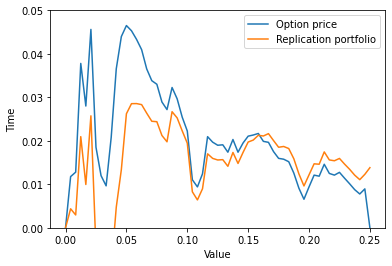

In [ ]:
### Solution ###

from scipy.misc import derivative

def barrier_price(i, s, m):
    if s >= b or m >= b:
        return 0
    if i == steps:
        return max(s-k, 0)

    max_sim = 100000
    batch_size = 1000
    x_mean = 0      # estimate of `E(X)`
    x_sq_mean = 0   # estimate of `E(X^2)`
    se = 0           # standard error of x
    n = 0           # batches counter (number of paths = n*batch_size)
    z = st.norm.ppf((1 + conf_prob) / 2)
    while (n==0 or (z*se/sqrt(n*batch_size) > error and n*batch_size < max_sim)):
      S = simulate(s, sigma, T[i], steps, batch_size)#using out previous function for simulation at time T[i]
      x = np.where(np.all(S <= b, axis = 1), np.maximum(S[:, -1] - k, 0), 0)#checking by rows condition on barrier and calculating the payoff
      x_mean = (x_mean*n + np.mean(x))/(n+1)
      x_sq_mean = (x_sq_mean*n + np.mean(x**2)) / (n+1)
      se = sqrt((n+1)*batch_size/((n+1)*batch_size-1) * (x_sq_mean - x_mean**2))
      n += 1
    return x_mean


# Option delta
def barrier_delta(i, s, m):
    return derivative(lambda x: barrier_price(i, x, m), s, dx=min(0.02, s/2))

# Replication
V_port = np.zeros(steps + 1)
H = np.zeros(steps + 1)
opt_pr = np.zeros(steps + 1)
V_port[0] = barrier_price(0, S[0], 0)
for i in range(steps):
  H[i] = barrier_delta(i, S[i], np.max(S[:i], initial = 0))#max before T[i]
  opt_pr[i] = barrier_price(i, S[i], np.max(S[:i], initial = 0))
  V_port[i + 1] = V_port[i] + H[i] * (S[i + 1] - S[i])

plt.plot(T, opt_pr, label = "Option price")
plt.plot(T, V_port, label = "Replication portfolio")
plt.xlabel("Value")
plt.ylabel("Time")
plt.ylim([0, 0.05])
plt.plot(T, np.full_like(T, b), linestyle="dashed", color="black")
plt.legend()
plt.show()